# Classification 

This notebook is for use classifying each of the observed clusters according to the Trumplar system. This is done using three parameters. a) Range of Brightness b) Degree of Concertration c) Cluster Population. Firstly loading required packages and processed data.


In [152]:
import numpy as np 
import pandas as pd 
import os 
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns 
color_palette = sns.color_palette("plasma")

from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from sklearn.cluster import dbscan
from sklearn.datasets import *
import hdbscan

import uncertainties
from uncertainties import ufloat_fromstr, ufloat 
from uncertainties import unumpy as unp

from astropy import wcs
from astropy.stats import mad_std
from astropy import units as u
from photutils import DAOStarFinder
from astropy.io import fits
from astropy.visualization import *
from photutils import *
from astropy.coordinates import Angle, SkyCoord
from isochrones.mist import MIST_Isochrone
from isochrones.dartmouth import Dartmouth_Isochrone
iso = MIST_Isochrone(bands=['B','V'])
iso_DARTH = Dartmouth_Isochrone(bands = ['B', 'V'])

In [153]:
# --- Plot Parameters ---- 
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 100
plt.rc('font', family = 'serif', serif = 'cmr10') 
plt.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': True,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            })
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
colour_arrays = ['red', 'blue', 'green', 'crimson', 'lime']


Loading astrometric images and photometry parameters. 

In [154]:
file_list = sorted(glob.glob('astrometric_obs_data/*.fits'))
print(file_list)

['astrometric_obs_data/Bochum2_B_wcs.fits', 'astrometric_obs_data/Bochum2_V_wcs.fits', 'astrometric_obs_data/NGC2324_B_wcs.fits', 'astrometric_obs_data/NGC2324_V_wcs.fits', 'astrometric_obs_data/NGC2355_B_wcs.fits', 'astrometric_obs_data/NGC2355_V_wcs.fits', 'astrometric_obs_data/berkeley28_B_wcs.fits', 'astrometric_obs_data/berkeley28_V_wcs.fits']


In [155]:
photo_params = pd.read_csv('calibration_parameters/photo_params.csv') # - loading photometry parameters previously calculated. 
photo_params.head()

,Name,FWHM_V,FWHM_B,Aper_V,Aper_B,bkg_V,bkg_B
0,Bochum 2,3.9,3.5,4.918034,2.599187,781.186107,778.034053
1,NGC2324,4.2,4.1,5.111358,3.183833,791.719962,791.116424
2,berkeley28,3.6,4.2,4.294812,2.251437,791.000000,783.000000
3,NGC2355,4.5,4.4,4.893446,3.350120,782.000000,852.000000


In [156]:
def lin_func(x, m, c): # - linear fit for magnitude calibration.
    return m*x + c 

mag_params = pd.read_csv('calibration_parameters/magnitude_processing/magnitude_cal.csv')

Loading previously defined star finder.

In [157]:
def starfinder(data, fwhm):
    mst_std = mad_std(data)
    daofind = DAOStarFinder(fwhm = fwhm, threshold = 5*mst_std)
    mst_sources = daofind(data)

    for col in mst_sources.colnames: 
        mst_sources[col].info.format = '%.8g'

    return mst_sources

Also using previous method of wcs co-ordinates to find simlarities in detection. However, this section of script is edited to calcualte the distance of a detected star from the clusters known center. 

In [158]:
def common_sources(filename_V, filename_B, v_sources_raw, b_sources_raw):
    vhdulist = fits.open(filename_V)
    v_wcs = wcs.WCS(vhdulist[0].header)
    x_cordv = v_sources_raw['xcentroid']; y_cordv = v_sources_raw['ycentroid']
    v_cord = v_wcs.pixel_to_world(x_cordv, y_cordv)

    bhdulist = fits.open(filename_B)
    x_cordb = b_sources_raw['xcentroid']; y_cordb = b_sources_raw['ycentroid']
    b_wcs = wcs.WCS(bhdulist[0].header)
    b_cord = b_wcs.pixel_to_world(x_cordb, y_cordb)
    vcoord_index = []; bcoord_index = []

    v_idx = 0
    for cord in v_cord: 
        sep2tar = cord.separation(b_cord).degree
        if sep2tar.min() < 1.73e-3: 
            vcoord_index.append(v_idx)
            bcoord_index.append(np.argmin(sep2tar))
        v_idx += 1 

    v_sources = v_sources_raw[vcoord_index]; b_sources = b_sources_raw[bcoord_index]

    if len(v_sources) != len(b_sources):
        print('HALT!') 
    else: 
        print('Common Targets:', len(v_sources))

    center =  v_wcs.pixel_to_world(np.shape(vhdulist[0].data)[0]/2, np.shape(vhdulist[0].data)[1]/2)

    sep2cntr = []; v_cord = v_wcs.pixel_to_world(x_cordv[vcoord_index], y_cordv[vcoord_index])
    for star in v_cord: 
        sep2cntr.append(center.separation(star).degree)

    return v_sources, b_sources, np.array(sep2cntr), v_cord

Re-incorporating the script for photometry and doing the signal to noise calculation as per data analysis review. 

\begin{equation}
SNR = \dfrac{N^{net}_{star}}{\sqrt{N^{net}_{star}+N_{sky}+N_{noise}}}
\end{equation}

In [159]:
def aper_photometry(data, sources, aper, bkg_counts):
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    
    # Aperture  
    aperture = CircularAperture(positions, r=aper)
    phot_table = aperture_photometry(data - bkg_counts, aperture)

    snr = np.array([])

    for col in phot_table.colnames[3:]:
        # bkg_total = bkg_counts*aperture.area
        net_star = phot_table[col] 
        snr = np.append(snr, net_star / np.sqrt(net_star))


    #- Now we get the final table of background subtracted counts for each star
    final_sum = phot_table['aperture_sum']

    return -2.5*np.log10(final_sum), snr

combing all the above steps in a unification function returns, 

In [160]:
def unifi_steps(filename_V, filename_B, table_index):

    data_B = fits.getdata(filename_B); data_V = fits.getdata(filename_V)
    fwhm_B = photo_params['FWHM_B'][table_index]; fwhm_V = photo_params['FWHM_V'][table_index]
    aper_B = photo_params['Aper_B'][table_index]; aper_V = photo_params['Aper_V'][table_index]
    bkg_B = photo_params['bkg_B'][table_index]; bkg_V = photo_params['bkg_V'][table_index]

    raw_B_sources = starfinder(data_B, fwhm_B) # returns list of sources from DAO. 
    raw_V_sources = starfinder(data_V, fwhm_V)

    fil_V_sources, fil_B_sources, seperation_values, target_coords = common_sources(filename_V, filename_B, raw_V_sources, raw_B_sources) # returns common sources between both B & V filters. 

    mag_V, snr_V = aper_photometry(data_V, fil_V_sources, aper_V, bkg_V)
    mag_B, snr_B = aper_photometry(data_B, fil_B_sources, aper_B, bkg_B)

    return mag_V, mag_B, snr_B, snr_V, fil_V_sources, fil_B_sources, seperation_values, target_coords

In [161]:
photo_params

,Name,FWHM_V,FWHM_B,Aper_V,Aper_B,bkg_V,bkg_B
0,Bochum 2,3.9,3.5,4.918034,2.599187,781.186107,778.034053
1,NGC2324,4.2,4.1,5.111358,3.183833,791.719962,791.116424
2,berkeley28,3.6,4.2,4.294812,2.251437,791.000000,783.000000
3,NGC2355,4.5,4.4,4.893446,3.350120,782.000000,852.000000


In [162]:
mag_params

,target,slope,constant,slope_err,constant_err
0,berkeley28_B,0.971244,23.975025,0.021307,0.177514
1,berkeley28_V,1.001256,24.526199,0.005840,0.057108
2,Bochum2_B,1.020409,24.677540,0.010366,0.095138
3,Bochum2_V,1.045326,25.174370,0.015138,0.158771
4,NGC2324_B,0.987966,24.082465,0.014919,0.140935
5,NGC2324_V,1.103228,25.465649,0.001510,0.016055
6,NGC2355_B,1.015697,24.756676,0.005128,0.051794
7,NGC2355_V,1.085197,25.624728,0.012554,0.126313


This cluster was used for intial tests as it was the poorest documented of the clusters observed. Here error analysis and attempts to classify and fit isochrones.
The instrumental magnitudes were calibrated to the APASS9 catalog (Johnson filters)

$$ \sigma_y =  \sqrt{ x^2 \sigma^2_m + \sigma^2_C + 2x \sigma_{mc}} $$ 

In [163]:
def covariance_propagation(x, slope_err, const_err): 
    return np.sqrt(x**2*slope_err**2 + const_err**2) #+ 2*x*slope_err)

Using Balesteros formula a estimation of temperture is made 

$$ T = 4600 \; \text{K}  \; \left( \frac{1}{0.92 \; B-V + 1.7}   + \frac{1}{0.92 \; B - V + 0.62}  \right) $$  

In [164]:
def balestero_temperture(BV):
    denom = 0.92*(BV)
    temp_ = 4600*(1/(denom + 1.7) + 1/(denom + 0.62))
    return temp_ 

## NGC 2324

Common Targets: 334


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


Average seperation from the center 2.8406284980049334
2.7216342112001355


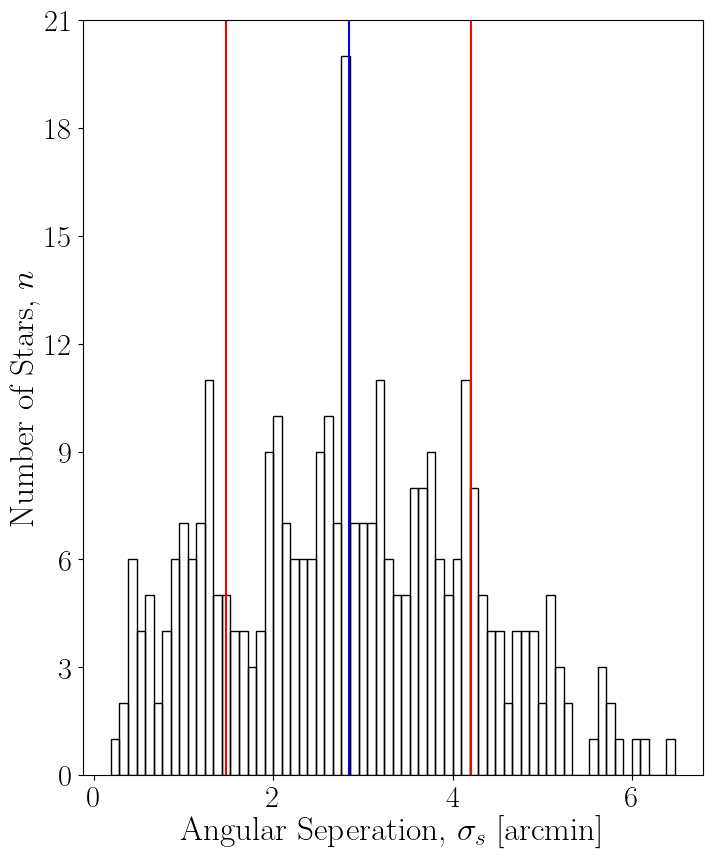

In [165]:
mag_V, mag_B, snr_B, snr_V, sources_V, sources_B, seperation, target_coords_v = unifi_steps('astrometric_obs_data/NGC2324_V_wcs.fits', 'astrometric_obs_data/NGC2324_B_wcs.fits', 1)

mag_Bc = lin_func(mag_B, mag_params['slope'][4], mag_params['constant'][4])
mag_Vc = lin_func(mag_V, mag_params['slope'][5], mag_params['constant'][5])

mag_V_err = covariance_propagation(mag_V, mag_params['slope_err'][1], mag_params['constant_err'][1])

nan_mask = np.in1d(np.isnan(mag_Bc), np.isnan(mag_Vc))
mag_Bc = mag_Bc[nan_mask]; mag_Vc = mag_Vc[nan_mask]
target_coords_v = target_coords_v[nan_mask]

data = pd.DataFrame({'mag_B': mag_Bc, 'emag_B':abs(1/snr_B)[nan_mask], 'mag_V':mag_Vc, 'emag_V':abs(1/snr_V)[nan_mask]})
data.to_csv('calibrated_mags/berkeley28.csv')

print('Average seperation from the center', seperation.mean()*60)

ax = plt.figure(figsize=(8, 10)).gca()
plt.hist(seperation*60, bins = int(len(sources_V)*0.2), facecolor = 'None', edgecolor = 'k')
plt.axvline(seperation.mean()*60, color = 'blue')
plt.axvline(seperation.mean()*60 + seperation.std()*60, color = 'red'); plt.axvline(seperation.mean()*60 - seperation.std()*60, color = 'red')
plt.xlabel('Angular Seperation, $\sigma_s$ [arcmin]', fontsize = 24); plt.ylabel('Number of Stars, $n$', fontsize = 24)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
print(seperation.std()*2*60)

In [166]:
clus_size = int(.05*len(mag_Vc))
cmd_data = np.transpose(np.array([mag_Vc, (mag_Bc - mag_Vc)]))

# -- DBSCAN Calculation -- 
preds = dbscan(cmd_data, .5, clus_size)[1]
dbscanned_data = np.append(cmd_data, preds.reshape(-1,1), axis=1)
scanned_dataframe = pd.DataFrame(dbscanned_data); scanned_dataframe = scanned_dataframe.rename(columns={0: "V_mag", 1: "BV_mag", 2: "cluster_no"})

print('Unique Clusters found', len(np.unique(scanned_dataframe['cluster_no'])))

for i in np.unique(scanned_dataframe['cluster_no']): 
    count = np.count_nonzero(scanned_dataframe['cluster_no'] == i)
    print(i, ':', count)

Unique Clusters found 2
-1.0 : 15
0.0 : 316


/Library/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass min_samples=16 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [167]:
cmd_data = np.transpose(np.array([mag_Vc, (mag_Bc - mag_Vc)]))

clusterer = hdbscan.HDBSCAN(min_cluster_size = clus_size).fit(cmd_data)
grouping = clusterer.labels_
probablities = clusterer.probabilities_

print('Unique clusters found:', len(np.unique(grouping)))
print('Respective sizes: \n ---')

for i in np.unique(grouping): 
    count = np.count_nonzero(grouping == i)
    print(i, ':', count)

# print('\n --- \n Probablities: \n', probablities)

Unique clusters found: 3
Respective sizes: 
 ---
-1 : 219
0 : 93
1 : 19


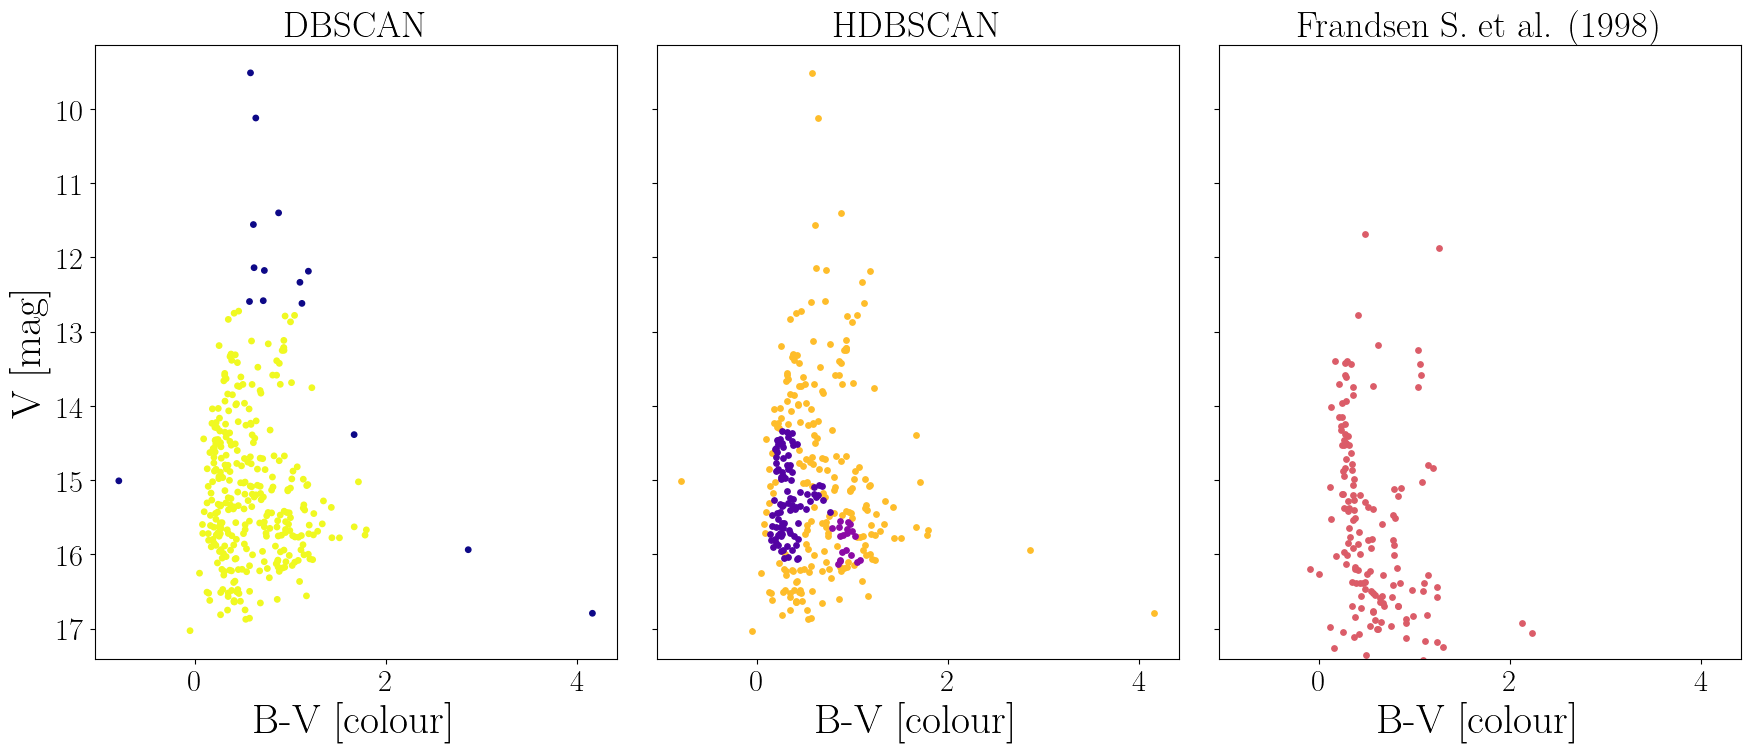

In [168]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,8), dpi = 100)

dot_size = 15

# fig.suptitle('Population Determination Comparison: NGC 2324')

# --- DBScan Plot --- 
ax1.scatter(scanned_dataframe['BV_mag'], scanned_dataframe['V_mag'], c = scanned_dataframe['cluster_no'], label = scanned_dataframe['cluster_no'], cmap = 'plasma', s = dot_size)
y_low, y_high = ax1.get_ylim(); x_low, x_high = ax1.get_xlim()
ax1.set_title('DBSCAN')
ax1.set_ylabel('V [mag]')


# --- HDBScan Plot --- 
c = 0
for i in np.unique(grouping):
    cluster_mask = np.where(grouping == i)
    ax2.scatter((mag_Bc - mag_Vc)[cluster_mask], mag_Vc[cluster_mask], s = dot_size, color = color_palette[i])
    c += 1
ax2.set_title('HDBSCAN')


# --- Archived Data Plot --- 
webda_V, webda_BV = np.loadtxt('calibration_parameters/magnitude_processing/NGC2324_WEBDA.txt', usecols = (2, 3), unpack = True)
ax3.scatter(webda_BV, webda_V, s = dot_size, color = color_palette[3])
ax3.set_xlim(x_low, x_high); ax3.set_ylim(y_low, y_high)
ax3.set_title('Frandsen S. et al. (1998)')


for ax in fig.get_axes():
    ax.label_outer()
    ax.set_xlabel('B-V [colour]')
    ax.invert_yaxis()

plt.tight_layout()

## Gaia Comparison 

In [169]:
def find_nearest(array, value):
    array = np.asarray(array); idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [170]:
gaia_data = pd.read_csv('gaia_cluster_populations/NGC2324.csv')
gaia_coords = SkyCoord(gaia_data['RA_ICRS'], gaia_data['DE_ICRS'],unit = 'deg')

matching_mags = []
for i in range(0, len(target_coords_v)): 
        sep2tar = target_coords_v[i].separation(gaia_coords).degree
        if sep2tar.min() < 1e-3: 
            matching_mags.append(i)
            
gaia_matched_B = mag_Bc[matching_mags]
# gaia_matched_V = mag_Vc[matching_mags]
print('\n This works:', len(gaia_matched_B), '\n 2021 Study: 242')
gaia_data.head()


 This works: 251 
 2021 Study: 242


,Unnamed: 0,RA_ICRS,DE_ICRS,e_RA_ICRS,e_DE_ICRS,mem_prob
0,0,106.008380,0.881757,0.2498,0.2384,1.000000
1,9,105.995933,0.893122,0.3791,0.4108,0.917581
2,10,105.999244,0.891119,0.1975,0.1847,1.000000
3,11,105.996237,0.886948,0.2556,0.2401,1.000000
4,13,106.001857,0.884655,0.4064,0.4229,1.000000


Common Targets: 334


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


Average seperation from the center 2.8406284980049334

 This works: 251 
 2021 Study: 261
   Unnamed: 0     RA_ICRS   DE_ICRS  e_RA_ICRS  e_DE_ICRS  mem_prob
0           0  106.008380  0.881757     0.2498     0.2384  1.000000
1           9  105.995933  0.893122     0.3791     0.4108  0.917581
2          10  105.999244  0.891119     0.1975     0.1847  1.000000
3          11  105.996237  0.886948     0.2556     0.2401  1.000000
4          13  106.001857  0.884655     0.4064     0.4229  1.000000
0.81+/-0.09


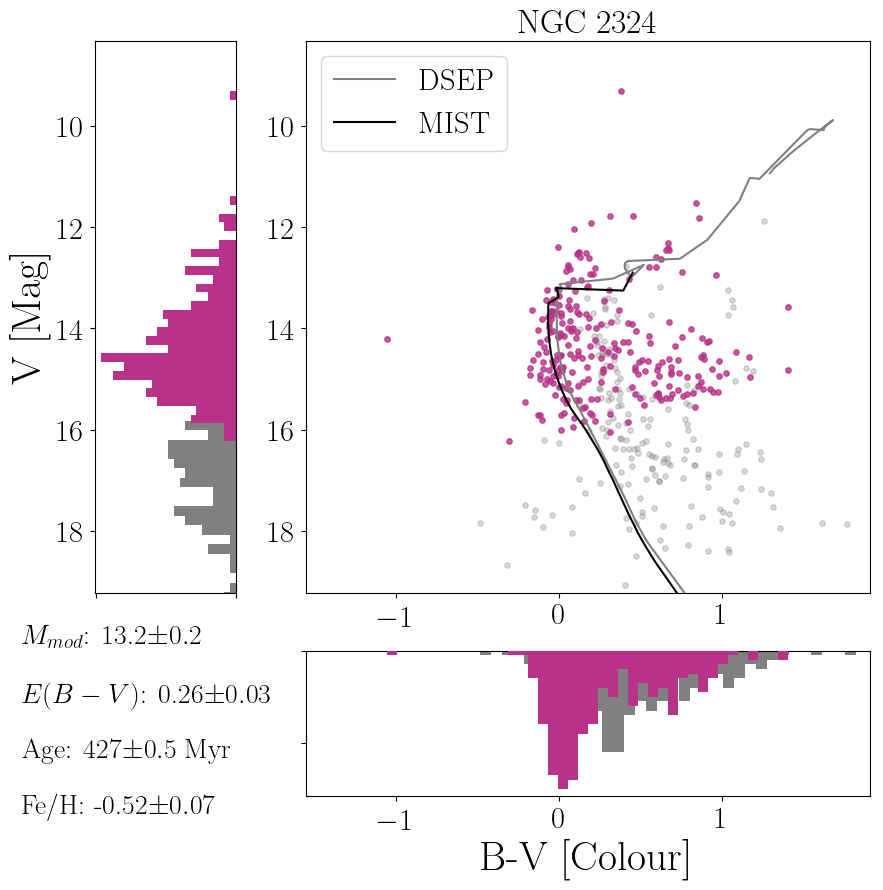

Average seperation from the center 2.8333696891213735


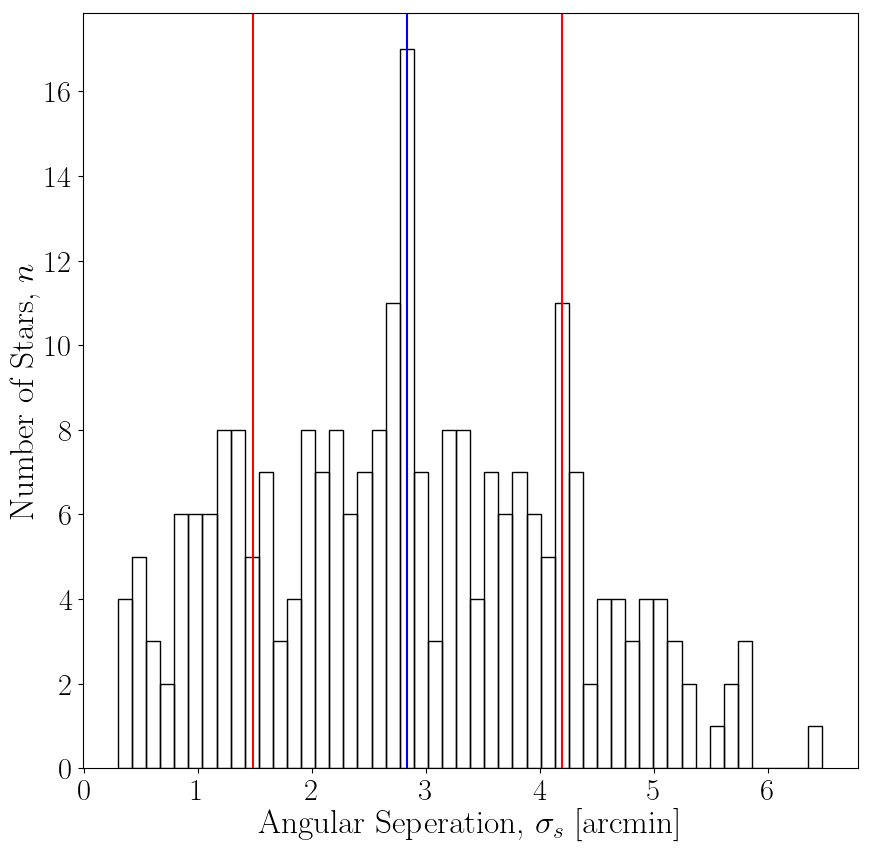

0.00576+/-0.00020
0.0049+/-0.0012


/Library/anaconda3/lib/python3.7/site-packages/astropy/visualization/stretch.py:538: RuntimeWarning: overflow encountered in sinh
  np.sinh(values, out=values)


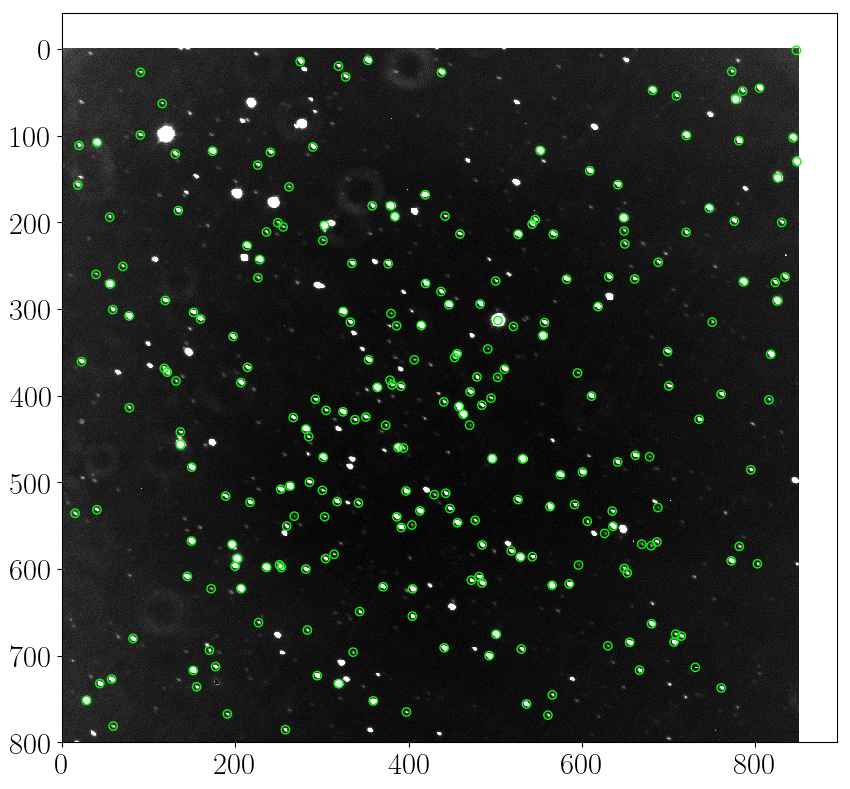

In [171]:
# --- Loading Data and CMD --- 
mag_V, mag_B, snr_B, snr_V, sources_V, sources_B, seperation, target_coords_v = unifi_steps('astrometric_obs_data/NGC2324_V_wcs.fits', 'astrometric_obs_data/NGC2324_B_wcs.fits', 1)

mag_Bc = lin_func(mag_B, mag_params['slope'][4], mag_params['constant'][4])
mag_Vc = lin_func(mag_V, mag_params['slope'][5], mag_params['constant'][5])

calibration_B_err = covariance_propagation(mag_B, mag_params['slope_err'][4], mag_params['constant_err'][4])
calibration_V_err = covariance_propagation(mag_V, mag_params['slope_err'][5], mag_params['constant_err'][5])

nan_mask = np.in1d(np.isnan(mag_Bc), np.isnan(mag_Vc))
mag_Bc = mag_Bc[nan_mask]; mag_Vc = mag_Vc[nan_mask]
target_coords_v = target_coords_v[nan_mask]



print('Average seperation from the center', seperation.mean()*60)

gaia_data = pd.read_csv('gaia_cluster_populations/NGC2324.csv')
gaia_coords = SkyCoord(gaia_data['RA_ICRS'], gaia_data['DE_ICRS'],unit = 'deg')

matching_mags = []
for i in range(0, len(target_coords_v)): 
        sep2tar = target_coords_v[i].separation(gaia_coords).degree
        if sep2tar.min() < 1e-3: 
            matching_mags.append(i)
            
print('\n This works:', len(matching_mags), '\n 2021 Study: 261')
print(gaia_data.head())

# --- Filtering and Propagating Errors --- 
target_coords_v = target_coords_v[matching_mags]
b_err = abs(1/snr_B)[nan_mask] + calibration_B_err[nan_mask]; v_err = abs(1/snr_V)[nan_mask] + calibration_V_err[nan_mask]
b_err = b_err[matching_mags]; v_err = v_err[matching_mags] # - Applying Nan and Gaia Maks. 

b_mags = unp.uarray(mag_Bc[matching_mags], b_err); v_mags = unp.uarray(mag_Vc[matching_mags], v_err)
bv_mags = b_mags - v_mags


# --- Archived Data for the plot --- 
webda_V, webda_BV = np.loadtxt('calibration_parameters/magnitude_processing/NGC2324_WEBDA.txt', usecols = (2, 3), unpack = True, skiprows=1)


# --- Plotting Isochrone and CMD --- 
# - Setting up grid for multi-histogram plot -
fig = plt.figure(figsize=(10, 10), dpi = 100)
grid = plt.GridSpec(4, 4, hspace=0.4, wspace=0.5)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

main_ax.set_title('NGC 2324', fontsize = 24)

# - Intialising and Fitting Isochrone 
color_excess = 0.26

color_err = 0.03
colour_total = ufloat(color_excess, color_err)
extinction = 3.1*colour_total

print(extinction) # -  error on extinction

v_mags = v_mags - extinction; bv_mags = bv_mags - colour_total

distance = 13.2
age_v = 8.63
feh_v = -0.52

y = np.array(unp.nominal_values(v_mags)); x = np.array(unp.nominal_values(bv_mags))

data = pd.DataFrame({'RA':np.round(target_coords_v.ra*u.degree, 5), 'DEC':np.round(target_coords_v.dec*u.degree, 5), 'mag_B': unp.nominal_values(b_mags), 'emag_B': unp.std_devs(b_mags),  \
     'mag_V':unp.nominal_values(v_mags), 'emag_V':unp.std_devs(v_mags), 'mag_BV': unp.nominal_values(bv_mags), 'emag_BV': unp.std_devs(bv_mags)})
data.to_csv('calibrated_mags/NGC2324.csv')

isochrone = iso_DARTH.isochrone(age = age_v, feh = feh_v)
modelv = isochrone['V_mag'] + distance
modelbv = (isochrone['B_mag'] - isochrone['V_mag'])
main_ax.plot(modelbv, modelv, color = 'grey', zorder = 4, label = 'DSEP')

isochrone = iso.isochrone(age = age_v, feh = feh_v)
modelv = isochrone['V_mag'] + distance
modelbv = (isochrone['B_mag'] - isochrone['V_mag'])
main_ax.plot(modelbv, modelv, color = 'k', zorder = 4, label = 'MIST')

pad = -3.3
annotate_font = 20
dot_size = 15

# --- Main Plot --- 
main_ax.scatter(x, y, color = color_palette[2], s=dot_size, alpha=0.8, zorder = 3) # - Filtered data
main_ax.scatter(webda_BV, webda_V, color = 'grey', s=dot_size, alpha=0.3, zorder = 0) # - WEBDA Data 
x_low, x_high = ((x.min() - 0.5), (x.max() + 0.5)); y_low, y_high = ((y.min() - 1), (y.max() + 3))
main_ax.set_xlim(x_low, x_high); main_ax.set_ylim(y_low, y_high)
main_ax.invert_yaxis()

# - Sub-histogram Data Plot - 
x_hist.hist(x, 40, histtype='stepfilled',
            orientation='vertical', color=color_palette[2], zorder = 3)
x_hist.hist(webda_BV, 40, histtype='stepfilled',
            orientation='vertical', color='grey', zorder = 0)
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled',
            orientation='horizontal', color=color_palette[2], zorder = 3)
y_hist.hist(webda_V, 40, histtype='stepfilled',
            orientation='horizontal', color='grey', zorder = 0)
y_hist.invert_xaxis()

main_ax.annotate(('$M_{mod}$: '+ '{:.1f}'.format(distance) + '$\pm 0.2$'), xy=(pad, -0.1), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)
main_ax.annotate(('$E(B-V)$: '+ '{:.2f}'.format(color_excess) + '$\pm 0.03$'), xy=(pad, -0.2), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)
main_ax.annotate(('Age: '+ '{:.0f}'.format((10**age_v)/10**6) + '$\pm 0.5$ Myr'), xy=(pad, -0.3), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)
main_ax.annotate(('Fe/H: '+ str(feh_v) + '$\pm 0.07$'), xy=(pad, -0.4), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)
main_ax.legend()

x_hist.set_xlabel('B-V [Colour]')
y_hist.set_ylabel('V [Mag]')

plt.savefig('plots/isochrones/NGC2324.pdf')
plt.show()

sources_V = sources_V[matching_mags]; seperation = seperation[matching_mags]
print('Average seperation from the center', seperation.mean()*60)
ax = plt.figure(figsize=(10, 10)).gca()
plt.hist(seperation*60, bins = int(len(sources_V)*0.2), facecolor = 'None', edgecolor = 'k')
plt.axvline(seperation.mean()*60, color = 'blue')
plt.axvline(seperation.mean()*60 + seperation.std()*60, color = 'red'); plt.axvline(seperation.mean()*60 - seperation.std()*60, color = 'red')
plt.xlabel('Angular Seperation, $\sigma_s$ [arcmin]', fontsize = 24); plt.ylabel('Number of Stars, $n$', fontsize = 24)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('plots/seperation/NGC2324.pdf')
plt.show()

print(np.diff(v_mags).mean())
print(np.diff(b_mags).mean())

ref = fits.getdata('astrometric_obs_data/NGC2324_V_wcs.fits')
norm = ImageNormalize(ref, interval=ZScaleInterval(), stretch=SinhStretch())
plt.imshow(ref, cmap=plt.cm.gray, norm=norm, interpolation='none')
plt.scatter(sources_V['xcentroid'], sources_V['ycentroid'], facecolor = 'none', edgecolors='lime')

# NGC 2355

Common Targets: 211


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


Average seperation from the center 2.7577813250835517

 This works: 139 
 2021 Study: 261
Uncertainty: 128
0.96+/-0.19 +- 0.19+/-0.04


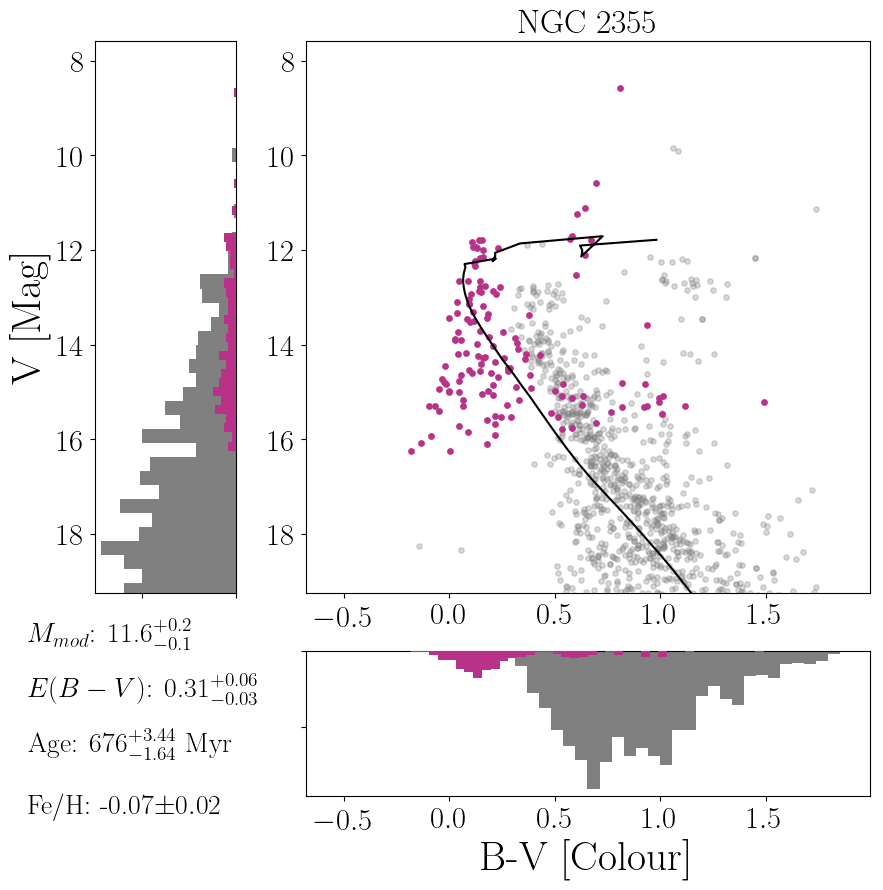

Average seperation from the center 2.517314378678211


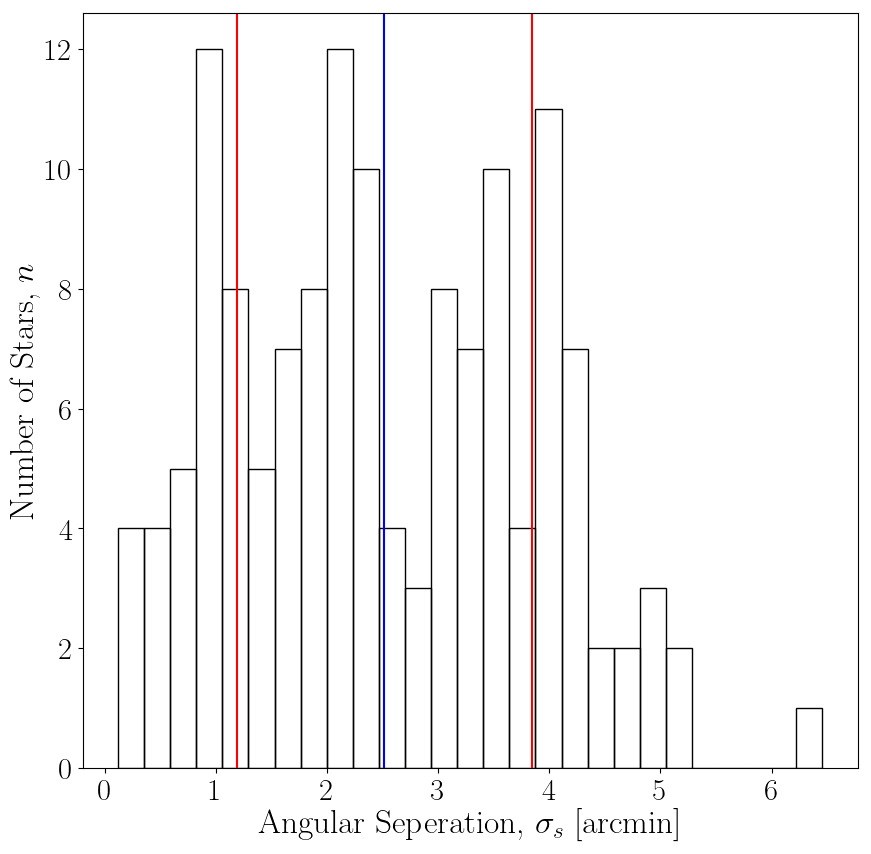

-0.0022+/-0.0019
-0.0067+/-0.0010


/Library/anaconda3/lib/python3.7/site-packages/astropy/visualization/stretch.py:538: RuntimeWarning: overflow encountered in sinh
  np.sinh(values, out=values)


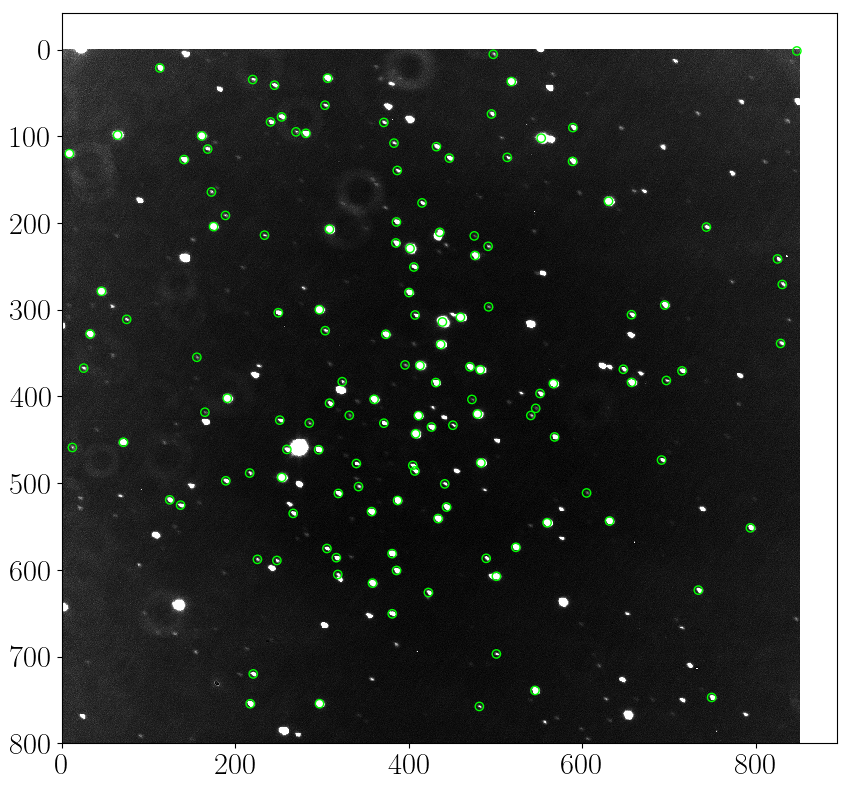

In [172]:
# --- Loading Data and CMD --- 
mag_V, mag_B, snr_B, snr_V, sources_V, sources_B, seperation, target_coords_v = unifi_steps('astrometric_obs_data/NGC2355_V_wcs.fits', 'astrometric_obs_data/NGC2355_B_wcs.fits', 3)

mag_Bc = lin_func(mag_B, mag_params['slope'][6], mag_params['constant'][6])
mag_Vc = lin_func(mag_V, mag_params['slope'][7], mag_params['constant'][7])

calibration_B_err = covariance_propagation(mag_B, mag_params['slope_err'][6], mag_params['constant_err'][6])
calibration_V_err = covariance_propagation(mag_V, mag_params['slope_err'][7], mag_params['constant_err'][7])

mag_V_err = covariance_propagation(mag_V, mag_params['slope_err'][3], mag_params['constant_err'][3])

nan_mask = np.in1d(np.isnan(mag_Bc), np.isnan(mag_Vc))
mag_Bc = mag_Bc[nan_mask]; mag_Vc = mag_Vc[nan_mask]
target_coords_v = target_coords_v[nan_mask]


print('Average seperation from the center', seperation.mean()*60)

gaia_data = pd.read_csv('gaia_cluster_populations/NGC2355.csv')
gaia_coords = SkyCoord(gaia_data['RA_ICRS'], gaia_data['DE_ICRS'],unit = 'deg')

matching_mags = []
for i in range(0, len(target_coords_v)): 
        sep2tar = target_coords_v[i].separation(gaia_coords).degree
        if sep2tar.min() < 1e-3: 
            matching_mags.append(i)
            
gaia_matched_B = mag_Bc[matching_mags]
gaia_matched_V = mag_Vc[matching_mags]
print('\n This works:', len(gaia_matched_B), '\n 2021 Study: 261')
gaia_data.head()


# --- Archived Data for the plot --- 
webda_V, webda_BV = np.loadtxt('calibration_parameters/magnitude_processing/NGC2355_WEBDA.txt', usecols = (2, 3), unpack = True, skiprows=1)


# --- Filtering and Propagating Errors --- 
target_coords_v = target_coords_v[matching_mags]

calibration_B_err = covariance_propagation(mag_B, mag_params['slope_err'][6], mag_params['constant_err'][6])
calibration_V_err = covariance_propagation(mag_V, mag_params['slope_err'][7], mag_params['constant_err'][7])


b_err = abs(1/snr_B)[nan_mask] + calibration_B_err[nan_mask]; v_err = abs(1/snr_V)[nan_mask] + calibration_V_err[nan_mask]
b_err = b_err[matching_mags]; v_err = v_err[matching_mags] # - Applying Nan and Gaia Maks. 

b_mags = unp.uarray(mag_Bc[matching_mags], b_err); v_mags = unp.uarray(mag_Vc[matching_mags], v_err)
bv_mags = b_mags - v_mags

mem_uncer = gaia_data['mem_prob'][matching_mags]
print('Uncertainty:', len(mem_uncer[mem_uncer < 0.8]))

y = np.array(unp.nominal_values(v_mags)); x = np.array(unp.nominal_values(bv_mags))


# - Setting up grid for multi-histogram plot -
fig = plt.figure(figsize=(10, 10), dpi = 100)
grid = plt.GridSpec(4, 4, hspace=0.4, wspace=0.5)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

color_excess = 0.31
color_err = 0.06
colour_total = ufloat(color_excess, color_err)
extinction = 3.1*colour_total
v_mags = v_mags - unp.nominal_values(extinction); bv_mags = bv_mags - unp.nominal_values(colour_total)
y = y - unp.nominal_values(extinction); x = x - unp.nominal_values(color_excess)

print('{:.2f}'.format(extinction), '+-', '{:.2f}'.format(color_err/color_excess*extinction)) # - percentage error on extinction



distance = 11.6
age_v = 8.83 
feh_v = -0.07

# isochrone = iso_DARTH.isochrone(age = age_v, feh = feh_v)
# modelv = isochrone['V_mag'] + distance
# modelbv = (isochrone['B_mag'] - isochrone['V_mag'])
# main_ax.plot(modelbv, modelv, color = 'grey', zorder = 4, label = 'DSEP')

isochrone = iso.isochrone(age = age_v, feh = feh_v)
modelv = isochrone['V_mag'] + distance
modelbv = (isochrone['B_mag'] - isochrone['V_mag'])
main_ax.plot(modelbv, modelv, color = 'k', zorder = 4, label = 'MIST')

pad = -2
annotate_font = 20

data = pd.DataFrame({'RA':np.round(target_coords_v.ra*u.degree, 5), 'DEC':np.round(target_coords_v.dec*u.degree, 5), 'mag_B': unp.nominal_values(b_mags), 'emag_B': unp.std_devs(b_mags),  \
     'mag_V':unp.nominal_values(v_mags), 'emag_V':unp.std_devs(v_mags), 'mag_BV': unp.nominal_values(bv_mags), 'emag_BV': unp.std_devs(bv_mags)})
data.to_csv('calibrated_mags/NGC2355.csv')


# --- Main Plot --- 
main_ax.scatter(x, y, color = color_palette[2], s=dot_size, alpha=1, zorder = 3) # - Filtered data
main_ax.scatter(webda_BV, webda_V, color = 'grey', s=dot_size, alpha=0.3, zorder = 0) # - WEBDA Data 
x_low, x_high = ((x.min() - 0.5), (x.max() + 0.5)); y_low, y_high = ((y.min() - 1), (y.max() + 3))
main_ax.set_title('NGC 2355', fontsize = 24)
main_ax.set_xlim(x_low, x_high); main_ax.set_ylim(y_low, y_high)
main_ax.invert_yaxis()


# - Sub-histogram Data Plot - 
x_hist.hist(x, 40, histtype='stepfilled',
            orientation='vertical', color=color_palette[2], zorder = 3)
x_hist.hist(webda_BV, 40, histtype='stepfilled',
            orientation='vertical', color='grey', zorder = 0)
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled',
            orientation='horizontal', color=color_palette[2], zorder = 3)
y_hist.hist(webda_V, 40, histtype='stepfilled',
            orientation='horizontal', color='grey', zorder = 0)
y_hist.invert_xaxis()


main_ax.annotate(('$M_{mod}$: '+ '{:.1f}'.format(distance) + '$^{+0.2}_{-0.1}$'), xy=(pad, -0.1), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)
main_ax.annotate(('$E(B-V)$: '+ '{:.2f}'.format(color_excess) + '$^{+0.06}_{-0.03}$'), xy=(pad, -0.2), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)
main_ax.annotate(('Age: '+ '{:.0f}'.format((10**age_v)/10**6) + '$^{+3.44}_{-1.64}$ Myr'), xy=(pad, -0.3), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)
main_ax.annotate(('Fe/H: '+ str(feh_v) + '$\pm 0.02$'), xy=(pad, -0.4), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)

# main_ax.axes.yaxis.set_ticklabels([])

x_hist.set_xlabel('B-V [Colour]')
y_hist.set_ylabel('V [Mag]')
plt.savefig('plots/isochrones/NGC2355.pdf')
plt.show()

sources_V = sources_V[matching_mags]; seperation = seperation[matching_mags]
print('Average seperation from the center', seperation.mean()*60)
ax = plt.figure(figsize=(10, 10)).gca()
plt.hist(seperation*60, bins = int(len(sources_V)*0.2), facecolor = 'None', edgecolor = 'k')
plt.axvline(seperation.mean()*60, color = 'blue')
plt.axvline(seperation.mean()*60 + seperation.std()*60, color = 'red'); plt.axvline(seperation.mean()*60 - seperation.std()*60, color = 'red')
plt.xlabel('Angular Seperation, $\sigma_s$ [arcmin]', fontsize = 24); plt.ylabel('Number of Stars, $n$', fontsize = 24)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('plots/seperation/NGC2355.pdf')
plt.show()

print(np.diff(v_mags).mean())
print(np.diff(b_mags).mean())

ref = fits.getdata('astrometric_obs_data/NGC2355_V_wcs.fits')
norm = ImageNormalize(ref, interval=ZScaleInterval(), stretch=SinhStretch())
plt.imshow(ref, cmap=plt.cm.gray, norm=norm, interpolation='none')
plt.scatter(sources_V['xcentroid'], sources_V['ycentroid'], facecolor = 'none', edgecolors='lime')

# Berkeley 28

Common Targets: 185


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


Average seperation from the center 2.9891215664898776

 This works: 79 
 2021 Study: 261
0.31+/-0.16 +- 0.16+/-0.08


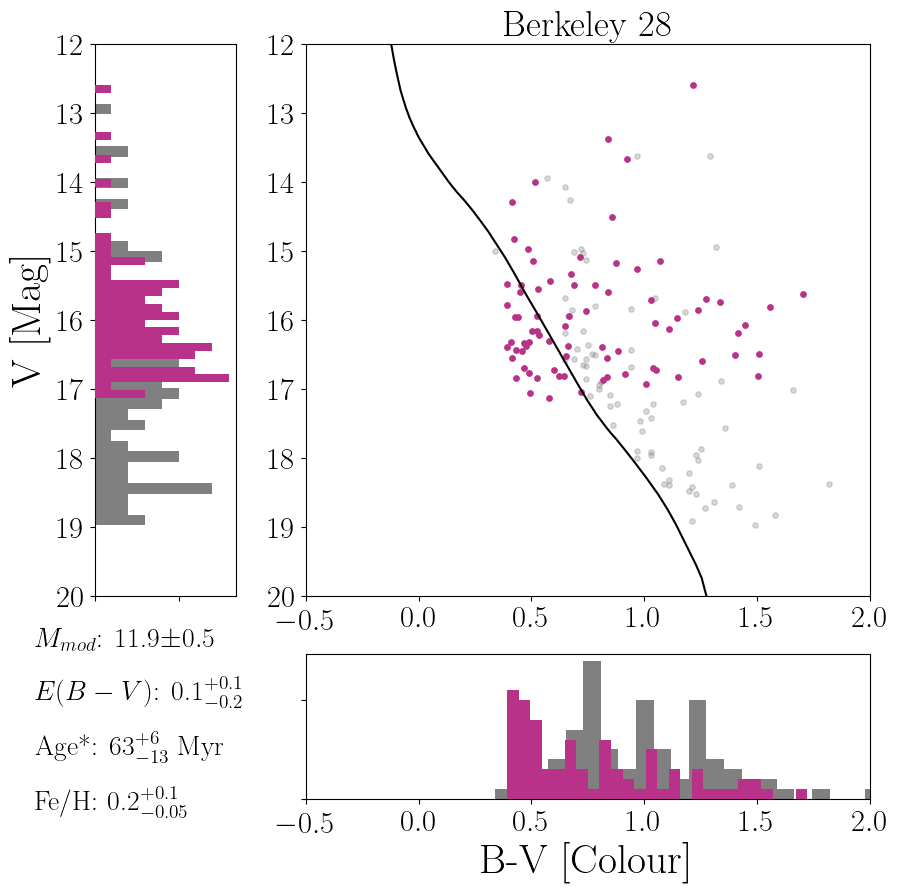

Average seperation from the center 2.6753886358149765


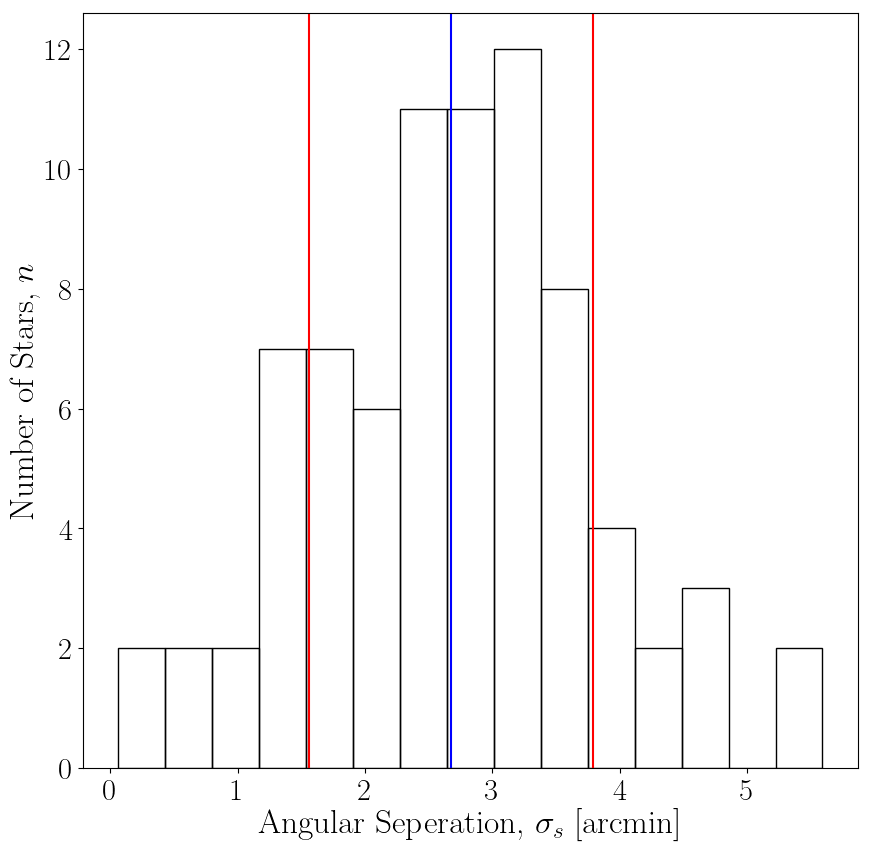

0.0017+/-0.0018
-0.010+/-0.005


/Library/anaconda3/lib/python3.7/site-packages/astropy/visualization/stretch.py:538: RuntimeWarning: overflow encountered in sinh
  np.sinh(values, out=values)


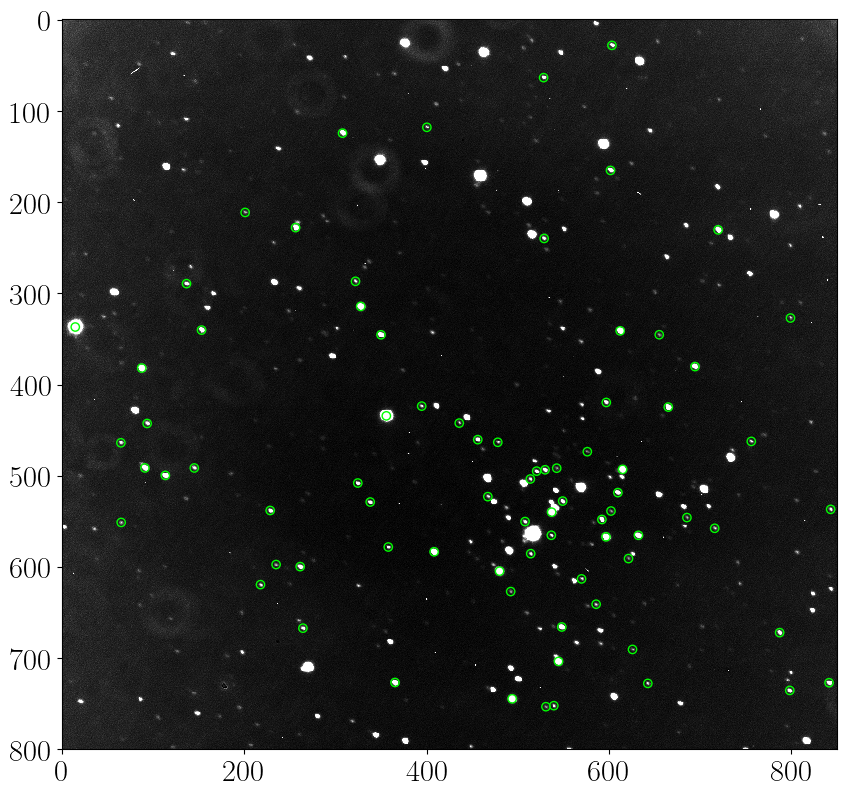

In [173]:
# --- Loading Data and CMD --- 
mag_V, mag_B, snr_B, snr_V, sources_V, sources_B, seperation, target_coords_v = unifi_steps('astrometric_obs_data/berkeley28_V_wcs.fits', 'astrometric_obs_data/berkeley28_B_wcs.fits', 2)

mag_Bc = lin_func(mag_B, mag_params['slope'][0], mag_params['constant'][0])
mag_Vc = lin_func(mag_V, mag_params['slope'][1], mag_params['constant'][1])

nan_mask = np.in1d(np.isnan(mag_Bc), np.isnan(mag_Vc))
mag_Bc = mag_Bc[nan_mask]; mag_Vc = mag_Vc[nan_mask]
target_coords_v = target_coords_v[nan_mask]

data = pd.DataFrame({'mag_B': mag_Bc, 'emag_B':abs(1/snr_B)[nan_mask], 'mag_V':mag_Vc, 'emag_V':abs(1/snr_V)[nan_mask]})
data.to_csv('calibrated_mags/berkeley28.csv')

print('Average seperation from the center', seperation.mean()*60)

gaia_data = pd.read_csv('gaia_cluster_populations/berkeley28.csv')
gaia_coords = SkyCoord(gaia_data['RA_ICRS'], gaia_data['DE_ICRS'],unit = 'deg')

matching_mags = []
for i in range(0, len(target_coords_v)): 
        sep2tar = target_coords_v[i].separation(gaia_coords).degree
        if sep2tar.min() < 1e-3: 
            matching_mags.append(i)
            
gaia_matched_B = mag_Bc[matching_mags]
gaia_matched_V = mag_Vc[matching_mags]
print('\n This works:', len(gaia_matched_B), '\n 2021 Study: 261')
gaia_data.head()

# --- Filtering and Propagating Errors --- 
calibration_B_err = covariance_propagation(mag_B, mag_params['slope_err'][0], mag_params['constant_err'][0])
calibration_V_err = covariance_propagation(mag_V, mag_params['slope_err'][1], mag_params['constant_err'][1])
target_coords_v = target_coords_v[matching_mags]
b_err = abs(1/snr_B)[nan_mask] + calibration_B_err[nan_mask]; v_err = abs(1/snr_V)[nan_mask] + calibration_V_err[nan_mask]
b_err = b_err[matching_mags]; v_err = v_err[matching_mags] # - Applying Nan and Gaia Maks. 
b_mags = unp.uarray(mag_Bc[matching_mags], b_err); v_mags = unp.uarray(mag_Vc[matching_mags], v_err)
bv_mags = b_mags - v_mags
# --- 

# --- No archived Data for Berkeley 28 ---

# --- Plotting Isochrone and CMD --- 
y = gaia_matched_V
x = (gaia_matched_B - gaia_matched_V)

# - Setting up grid for multi-histogram plot -
fig = plt.figure(figsize=(10, 10), dpi = 100)
grid = plt.GridSpec(4, 4, hspace=0.4, wspace=0.5)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

# --- 
color_excess = 0.1
color_err = 0.05
colour_total = ufloat(color_excess, color_err)
extinction = 3.1*colour_total
v_mags = v_mags - extinction; bv_mags = bv_mags - colour_total
y = y - unp.nominal_values(extinction); x = x - unp.nominal_values(color_excess)
# --- 

print('{:.2f}'.format(extinction), '+-', '{:.2f}'.format(color_err/color_excess*extinction)) # - percentage error on extinction

distance = 11.9
age_v = 7.8 
feh_v = 0.2

# --- Archived Data for the plot --- 
webda_V, webda_BV = np.loadtxt('calibration_parameters/magnitude_processing/Berkeley28_WEBDA.txt', usecols = (2, 3), unpack = True, skiprows=1)

isochrone = iso.isochrone(age = age_v, feh = feh_v)
modelv = isochrone['V_mag'] + distance
modelbv = (isochrone['B_mag'] - isochrone['V_mag'])
main_ax.plot(modelbv, modelv, color = 'k', zorder = 4, label = 'MIST')

pad = -1.7
annotate_font = 20

# --- Main Plot --- 
main_ax.scatter(x, y, color = color_palette[2], s=dot_size, alpha=1, zorder = 3) # - Filtered data
main_ax.scatter(webda_BV, webda_V, color = 'grey', s=dot_size, alpha=0.3, zorder = 0) # - WEBDA Data 
# x_low, x_high = ((x.min() - 0.5), (x.max() + 0.5)); y_low, y_high = ((y.min() - 1), (y.max() + 3))

# - Sub-histogram Data Plot - 
x_hist.hist(x, 40, histtype='stepfilled',
            orientation='vertical', color=color_palette[2], zorder = 3)
x_hist.hist(webda_BV, 40, histtype='stepfilled',
            orientation='vertical', color='grey', zorder = 0)
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled',
            orientation='horizontal', color=color_palette[2], zorder = 3)
y_hist.hist(webda_V, 40, histtype='stepfilled',
            orientation='horizontal', color='grey', zorder = 0)
y_hist.invert_xaxis()

# - Sub-histogram Data Plot - 
x_hist.hist(x, 40, histtype='stepfilled',
            orientation='vertical', color=color_palette[2], zorder = 3)
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled',
            orientation='horizontal', color=color_palette[2], zorder = 3)
y_hist.invert_xaxis()

main_ax.set_xlim(-0.5, 2); main_ax.set_ylim(12, 20)
main_ax.invert_yaxis()


main_ax.annotate(('$M_{mod}$: '+ '{:.1f}'.format(distance) + '${\pm 0.5}$'), xy=(pad, -0.1), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)
main_ax.annotate(('$E(B-V)$: '+ str(color_excess) + '$^{+0.1}_{-0.2}$'), xy=(pad, -0.2), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)
main_ax.annotate(('Age*: '+ '{:.0f}'.format((10**age_v)/10**6) + '$_{-13}^{+6}$ Myr'), xy=(pad, -0.3), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)
main_ax.annotate(('Fe/H: '+ str(feh_v) + '$_{-0.05}^{+0.1}$'), xy=(pad, -0.4), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)
main_ax.set_title('Berkeley 28')

# main_ax.axes.yaxis.set_ticklabels([])

x_hist.set_xlabel('B-V [Colour]')
y_hist.set_ylabel('V [Mag]')
plt.savefig('plots/isochrones/Berkeley28.pdf')
plt.show()

data = pd.DataFrame({'RA':np.round(target_coords_v.ra*u.degree, 5), 'DEC':np.round(target_coords_v.dec*u.degree, 5), 'mag_B': unp.nominal_values(b_mags), 'emag_B': unp.std_devs(b_mags),  \
     'mag_V':unp.nominal_values(v_mags), 'emag_V':unp.std_devs(v_mags), 'mag_BV': unp.nominal_values(bv_mags), 'emag_BV': unp.std_devs(bv_mags)})
data.to_csv('calibrated_mags/Berkeley28.csv')

sources_V = sources_V[matching_mags]; seperation = seperation[matching_mags]
print('Average seperation from the center', seperation.mean()*60)
ax = plt.figure(figsize=(10, 10)).gca()
plt.hist(seperation*60, bins = int(len(sources_V)*0.2), facecolor = 'None', edgecolor = 'k')
plt.axvline(seperation.mean()*60, color = 'blue')
plt.axvline(seperation.mean()*60 + seperation.std()*60, color = 'red'); plt.axvline(seperation.mean()*60 - seperation.std()*60, color = 'red')
plt.xlabel('Angular Seperation, $\sigma_s$ [arcmin]', fontsize = 24); plt.ylabel('Number of Stars, $n$', fontsize = 24)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('plots/seperation/Berkeley28.pdf')
plt.show()

print(np.diff(v_mags).mean())
print(np.diff(b_mags).mean())

ref = fits.getdata('astrometric_obs_data/Berkeley28_V_wcs.fits')
norm = ImageNormalize(ref, interval=ZScaleInterval(), stretch=SinhStretch())
plt.imshow(ref, cmap=plt.cm.gray, norm=norm, interpolation='none')
plt.scatter(sources_V['xcentroid'], sources_V['ycentroid'], facecolor = 'none', edgecolors='lime')


In [174]:
test = gaia_data['mem_prob'][matching_mags]
test.mean()

0.8995105988577667

# Bochum 2

Common Targets: 145
Average seperation from the center 3.1461799266013366

 This works: 110 
 2021 Study: 261
1.98+/-0.31 +- 0.31+/-0.05


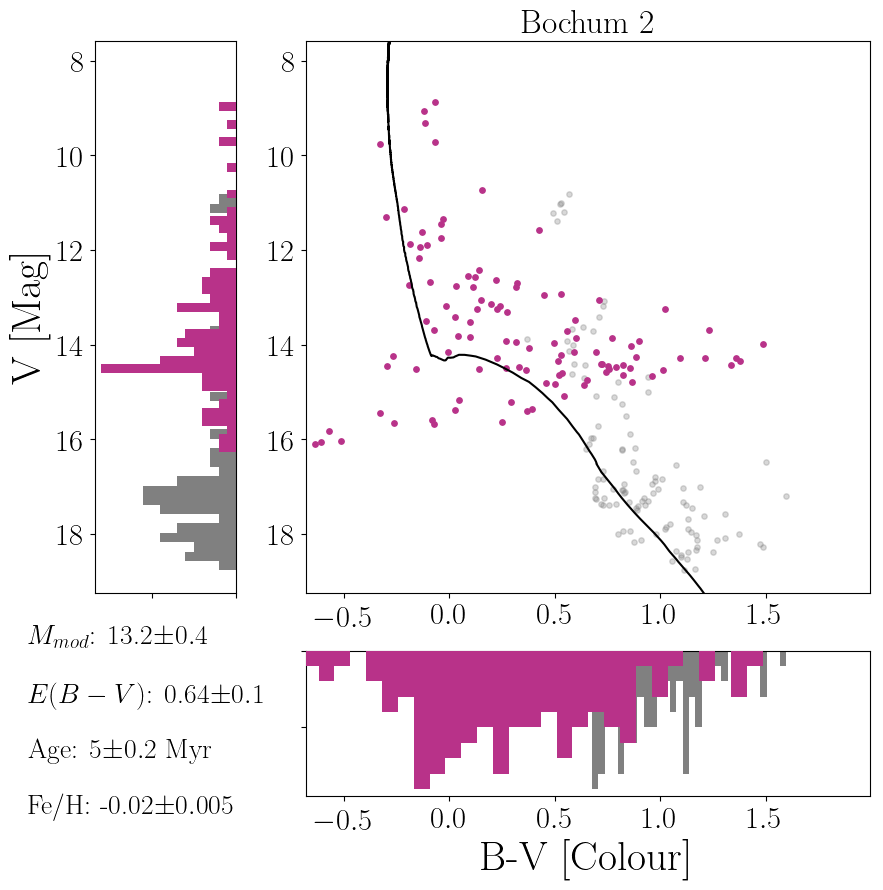

Average seperation from the center 3.2631489885737364


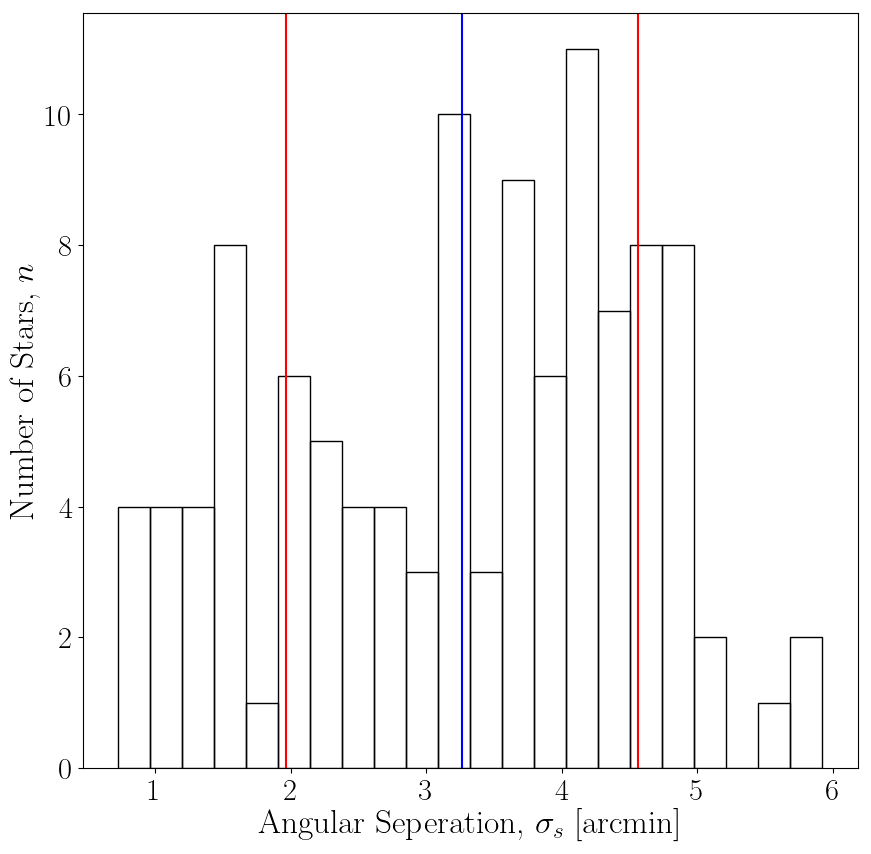

0.0160+/-0.0030
0.0211+/-0.0020


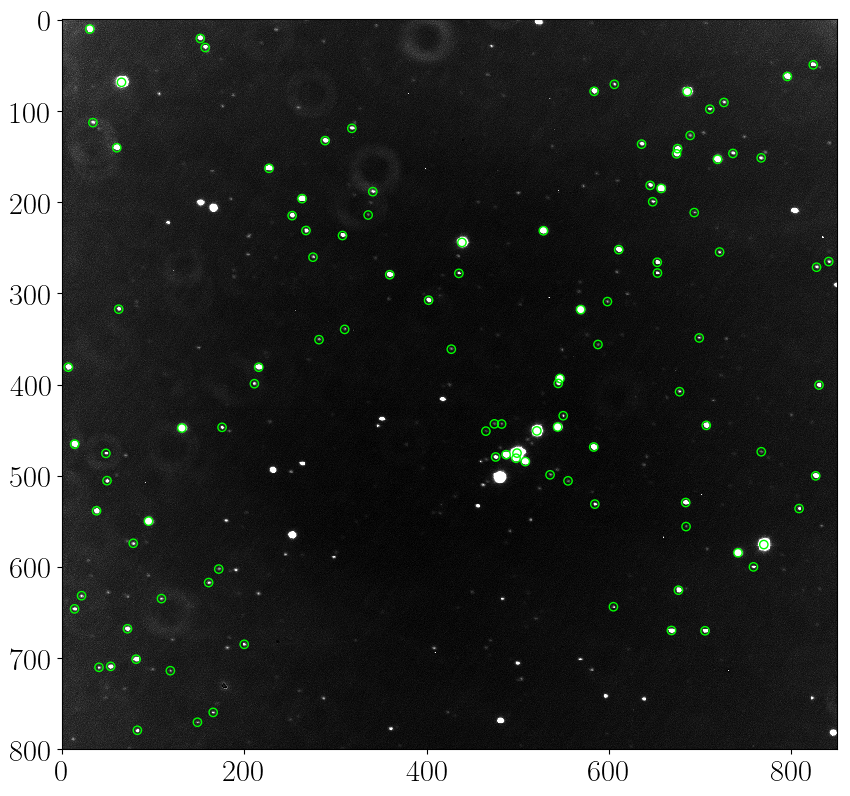

In [175]:
# --- Loading Data and CMD --- 
mag_V, mag_B, snr_B, snr_V, sources_V, sources_B, seperation, target_coords_v = unifi_steps('astrometric_obs_data/Bochum2_V_wcs.fits', 'astrometric_obs_data/Bochum2_B_wcs.fits', 0)

mag_Bc = lin_func(mag_B, mag_params['slope'][2], mag_params['constant'][2])
mag_Vc = lin_func(mag_V, mag_params['slope'][3], mag_params['constant'][3])

mag_V_err = covariance_propagation(mag_V, mag_params['slope_err'][3], mag_params['constant_err'][3])

nan_mask = np.in1d(np.isnan(mag_Bc), np.isnan(mag_Vc))
mag_Bc = mag_Bc[nan_mask]; mag_Vc = mag_Vc[nan_mask]
target_coords_v = target_coords_v[nan_mask]

data = pd.DataFrame({'mag_B': mag_Bc, 'emag_B':abs(1/snr_B)[nan_mask], 'mag_V':mag_Vc, 'emag_V':abs(1/snr_V)[nan_mask]})
data.to_csv('calibrated_mags/Bochum2.csv')

print('Average seperation from the center', seperation.mean()*60)

gaia_data = pd.read_csv('gaia_cluster_populations/Bochum2.csv')
gaia_coords = SkyCoord(gaia_data['RA_ICRS'], gaia_data['DE_ICRS'],unit = 'deg')

matching_mags = []
for i in range(0, len(target_coords_v)): 
        sep2tar = target_coords_v[i].separation(gaia_coords).degree
        if sep2tar.min() < 1e-3: 
            matching_mags.append(i)
            
gaia_matched_B = mag_Bc[matching_mags]
gaia_matched_V = mag_Vc[matching_mags]
print('\n This works:', len(gaia_matched_B), '\n 2021 Study: 261')
gaia_data.head()

# --- Filtering and Propagating Errors --- 
calibration_B_err = covariance_propagation(mag_B, mag_params['slope_err'][2], mag_params['constant_err'][2])
calibration_V_err = covariance_propagation(mag_V, mag_params['slope_err'][3], mag_params['constant_err'][3])
target_coords_v = target_coords_v[matching_mags]
b_err = abs(1/snr_B)[nan_mask] + calibration_B_err[nan_mask]; v_err = abs(1/snr_V)[nan_mask] + calibration_V_err[nan_mask]
b_err = b_err[matching_mags]; v_err = v_err[matching_mags] # - Applying Nan and Gaia Maks. 
b_mags = unp.uarray(mag_Bc[matching_mags], b_err); v_mags = unp.uarray(mag_Vc[matching_mags], v_err)
bv_mags = b_mags - v_mags
# --- 


# --- Archived Data for the plot --- 
webda_V, webda_BV = np.loadtxt('calibration_parameters/magnitude_processing/Bochum2_WEBDA.txt', usecols = (2, 3), unpack = True, skiprows=1)


# --- Plotting Isochrone and CMD --- 
y = gaia_matched_V
x = (gaia_matched_B - gaia_matched_V)

# y = mag_Vc
# x = (mag_Bc - mag_Vc)

# - Setting up grid for multi-histogram plot -
fig = plt.figure(figsize=(10, 10), dpi = 100)
grid = plt.GridSpec(4, 4, hspace=0.4, wspace=0.5)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)



# - Intialising and Fitting Isochrone 
# --- 
color_excess = 0.64
color_err = 0.1
colour_total = ufloat(color_excess, color_err)
extinction = 3.1*colour_total
v_mags = v_mags - extinction; bv_mags = bv_mags - colour_total
y = y - unp.nominal_values(extinction); x = x - unp.nominal_values(color_excess)
# --- 

print('{:.2f}'.format(extinction), '+-', '{:.2f}'.format(color_err/color_excess*extinction)) # - percentage error on extinction

distance = 13.2
age_v = 6.68
feh_v = -0.02

# isochrone = iso_DARTH.isochrone(age = age_v, feh = feh_v)
# modelv = isochrone['V_mag'] + distance
# modelbv = (isochrone['B_mag'] - isochrone['V_mag'])
# main_ax.plot(modelbv, modelv, color = 'grey', zorder = 4, label = 'DSEP')

isochrone = iso.isochrone(age = age_v, feh = feh_v)
modelv = isochrone['V_mag'] + distance
modelbv = (isochrone['B_mag'] - isochrone['V_mag'])
main_ax.plot(modelbv, modelv, color = 'k', zorder = 4, label = 'MIST')

pad = -2
annotate_font = 20

# --- Main Plot --- 
main_ax.scatter(x, y, color = color_palette[2], s=dot_size, alpha=1, zorder = 3) # - Filtered data
main_ax.scatter(webda_BV, webda_V, color = 'grey', s=dot_size, alpha=0.3, zorder = 0) # - WEBDA Data 
# x_low, x_high = ((x.min() - 0.5), (x.max() + 0.5)); y_low, y_high = ((y.min() - 1), (y.max() + 3))

# - Sub-histogram Data Plot - 
x_hist.hist(x, 40, histtype='stepfilled',
            orientation='vertical', color=color_palette[2], zorder = 3)
x_hist.hist(webda_BV, 40, histtype='stepfilled',
            orientation='vertical', color='grey', zorder = 0)
x_hist.invert_yaxis()

y_hist.hist(y, 40, histtype='stepfilled',
            orientation='horizontal', color=color_palette[2], zorder = 3)
y_hist.hist(webda_V, 40, histtype='stepfilled',
            orientation='horizontal', color='grey', zorder = 0)
y_hist.invert_xaxis()

main_ax.annotate(('$M_{mod}$: '+ '{:.1f}'.format(distance) + '$\pm 0.4$'), xy=(pad, -0.1), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)
main_ax.annotate(('$E(B-V)$: '+ '{:.2f}'.format(color_excess) + '$\pm 0.1$'), xy=(pad, -0.2), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)
main_ax.annotate(('Age: '+ '{:.0f}'.format((10**age_v)/10**6) + '$\pm 0.2$ Myr'), xy=(pad, -0.3), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)
main_ax.annotate(('Fe/H: '+ str(feh_v) + '$\pm 0.005$'), xy=(pad, -0.4), xycoords=main_ax.get_xaxis_transform(), fontsize = annotate_font)

main_ax.set_title('Bochum 2', fontsize = 24)
main_ax.set_xlim(x_low, x_high); main_ax.set_ylim(y_low, y_high)
main_ax.invert_yaxis()

# main_ax.axes.yaxis.set_ticklabels([])

x_hist.set_xlabel('B-V [Colour]')
y_hist.set_ylabel('V [Mag]')
# plt.tight_layout()
# plt.legend()
plt.savefig('plots/isochrones/Bochum2.pdf')
plt.show()

data = pd.DataFrame({'RA':np.round(target_coords_v.ra*u.degree, 5), 'DEC':np.round(target_coords_v.dec*u.degree, 5), 'mag_B': unp.nominal_values(b_mags), 'emag_B': unp.std_devs(b_mags),  \
     'mag_V':unp.nominal_values(v_mags), 'emag_V':unp.std_devs(v_mags), 'mag_BV': unp.nominal_values(bv_mags), 'emag_BV': unp.std_devs(bv_mags)})
data.to_csv('calibrated_mags/Bochum2.csv')


sources_V = sources_V[matching_mags]; seperation = seperation[matching_mags]
print('Average seperation from the center', seperation.mean()*60)
ax = plt.figure(figsize=(10, 10)).gca()
plt.hist(seperation*60, bins = int(len(sources_V)*0.2), facecolor = 'None', edgecolor = 'k')
plt.axvline(seperation.mean()*60, color = 'blue')
plt.axvline(seperation.mean()*60 + seperation.std()*60, color = 'red'); plt.axvline(seperation.mean()*60 - seperation.std()*60, color = 'red')
plt.xlabel('Angular Seperation, $\sigma_s$ [arcmin]', fontsize = 24); plt.ylabel('Number of Stars, $n$', fontsize = 24)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('plots/seperation/Bochum2.pdf')
plt.show()

print(np.diff(v_mags).mean())
print(np.diff(b_mags).mean())

ref = fits.getdata('astrometric_obs_data/Bochum2_V_wcs.fits')
norm = ImageNormalize(ref, interval=ZScaleInterval(), stretch=SinhStretch())
plt.imshow(ref, cmap=plt.cm.gray, norm=norm, interpolation='none')
plt.scatter(sources_V['xcentroid'], sources_V['ycentroid'], facecolor = 'none', edgecolors='lime')

In [176]:
test = gaia_data['mem_prob'][matching_mags]
len(test[test < 0.9])

/Library/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


13